# AutoEncoder

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [3]:
# 设置随机种子
import random
import numpy as np
import tensorflow as tf

# 试了一下，1，2，3，42都是负相关的，4、6、7、8是正相关，感觉正相关更好解释一点
seed_value = 7

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


tf.keras.utils.set_random_seed(seed_value)

In [4]:
import pandas as pd
df = pd.read_excel('data/Copy of 2023_MCM_Problem_C_Data.xlsx')

## 数据处理

- 由于很多项数值合不是100，不符合百分合为100%的特征，所以这里通过将最大值减小的方式以取保总和为100
  - 这方法比较简单粗暴，之后可能要再修改

In [5]:
# 数据预处理：选择数值特征列
import numpy as np

# 选择数值特征列（去除日期、单词等非数值列）
numeric_cols = ['1 try', '2 tries', '3 tries', '4 tries', '5 tries', '6 tries', '7 or more tries (X)']

# 提取数值数据
data_numeric = df[numeric_cols].values.astype(np.float32)

print(f"原始数据形状: {data_numeric.shape}")
print(f"特征维度: {data_numeric.shape[1]}")

原始数据形状: (359, 7)
特征维度: 7


In [6]:
# 将数据分割为训练集和测试集（类似 fashion_mnist 的格式）
from sklearn.model_selection import train_test_split

# 分割数据：80% 训练集，20% 测试集
x_train, x_test = train_test_split(data_numeric, test_size=0.2, random_state=42)

# 归一化：使每行7个值的和为100，且都是整数
# 1. 先按比例归一化
x_train_normalized = x_train / x_train.sum(axis=1, keepdims=True) * 100
x_test_normalized = x_test / x_test.sum(axis=1, keepdims=True) * 100

# 2. 四舍五入取整
x_train = np.round(x_train_normalized).astype('int32')
x_test = np.round(x_test_normalized).astype('int32')

# 3. 修正误差，确保每行和恰好为100
for i in range(len(x_train)):
    diff = 100 - x_train[i].sum()
    if diff != 0:
        # 找到最大值的索引，调整它来补偿误差
        max_idx = x_train[i].argmax()
        x_train[i, max_idx] += diff
# 再进行一遍以检查
for i in range(len(x_test)):
    diff = 100 - x_test[i].sum()
    if diff != 0:
        max_idx = x_test[i].argmax()
        x_test[i, max_idx] += diff

# 4. 转换为float32并归一化到[0, 1]范围（用于训练）
x_train = x_train.astype('float32') / 100.0
x_test = x_test.astype('float32') / 100.0

print(f"训练集形状: {x_train.shape}")
print(f"测试集形状: {x_test.shape}")

训练集形状: (287, 7)
测试集形状: (72, 7)


## 模型训练

In [7]:
latent_dim = 1 # 最后放缩维度为1

# 自编码器模型
# 方法介绍:
# 这是一个针对Wordle游戏尝试次数分布数据的自编码器
# 输入: 7个特征 (1-7次尝试的百分比分布), 归一化到[0,1]范围
# 编码: 通过浅层神经网络压缩到1维潜在空间
# 解码: 重构回7维分布
# 关键改进: 使用softmax确保输出满足概率分布约束(和为1)
# 适用场景: 降维、特征提取、异常检测

class Autoencoder(Model):
  def __init__(self, latent_dim, input_dim=7):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.input_dim = input_dim
    # 先降到4维，再由4维降到1维
    self.encoder = tf.keras.Sequential([
      layers.Dense(4, activation='relu'),
      layers.Dense(latent_dim, activation='linear'),
    ])
    self.decoder = tf.keras.Sequential([
    # 先升到1维，再由1维升到4维
      layers.Dense(4, activation='relu'),
      layers.Dense(input_dim, activation='linear'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    
    # 使用 softmax 确保输出在 [0, 1] 范围且和为1（符合百分比约束）
    decoded_normalized = tf.nn.softmax(decoded, axis=-1)
    
    return decoded_normalized

autoencoder = Autoencoder(latent_dim, input_dim=7)


In [8]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(x_train, x_train,
                epochs=2000, # 1000轮后模型的优化就已经很有限了
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0156 - val_loss: 0.0156
Epoch 2/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152 - val_loss: 0.0151
Epoch 3/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147 - val_loss: 0.0147
Epoch 4/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0142 - val_loss: 0.0142
Epoch 5/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138 - val_loss: 0.0137
Epoch 6/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0132 - val_loss: 0.0132
Epoch 7/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - val_loss: 0.0126
Epoch 8/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122 - val_loss: 0.0121
Epoch 9/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116 - val_loss: 0.0115
Epoch 10/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 11/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104 - val_loss: 0.0102
Epoch 12/2000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0097 - val_lo

In [9]:
# 合并训练集和测试集，使用所有数据
x_all = np.concatenate([x_train, x_test], axis=0)

print(f"合并后的总数据量: {x_all.shape}")
print(f"  训练集: {x_train.shape[0]} 条")
print(f"  测试集: {x_test.shape[0]} 条")
print(f"  总计: {x_all.shape[0]} 条")

# 使用训练好的模型对所有数据进行编码和解码
encoded_data = autoencoder.encoder(x_all).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

print(f"\n所有数据的编码和解码结果:")
print(f"  原始数据形状: {x_all.shape}")
print(f"  编码后形状: {encoded_data.shape}")
print(f"  解码后形状: {decoded_data.shape}")
print(f"  编码数据范围: [{encoded_data.min():.3f}, {encoded_data.max():.3f}]")

# 计算整体重构误差
overall_mse = np.mean((x_all - decoded_data)**2)
overall_mae = np.mean(np.abs(x_all - decoded_data))

print(f"\n整体重构误差:")
print(f"  MSE: {overall_mse:.6f}")
print(f"  MAE: {overall_mae:.6f}")

# 显示前5个样本的编码值
print(f"\n前5个样本的潜在空间编码:")
print(encoded_data[:5])

# 验证解码后数据的和（应该都接近1.0）
print(f"\n解码数据的和验证:")
print(f"  平均和: {decoded_data.sum(axis=1).mean():.6f}")
print(f"  最小和: {decoded_data.sum(axis=1).min():.6f}")
print(f"  最大和: {decoded_data.sum(axis=1).max():.6f}")

合并后的总数据量: (359, 7)
  训练集: 287 条
  测试集: 72 条
  总计: 359 条

所有数据的编码和解码结果:
  原始数据形状: (359, 7)
  编码后形状: (359, 1)
  解码后形状: (359, 7)
  编码数据范围: [-1.693, 2.241]

整体重构误差:
  MSE: 3.560913
  MAE: 1.330543

前5个样本的潜在空间编码:
[[-0.4368641 ]
 [-0.45090005]
 [-1.0206125 ]
 [-1.1520001 ]
 [-0.8645941 ]]

解码数据的和验证:
  平均和: -2.969436
  最小和: -9.310369
  最大和: -0.510552


## 模型检验

### 样本数据对比

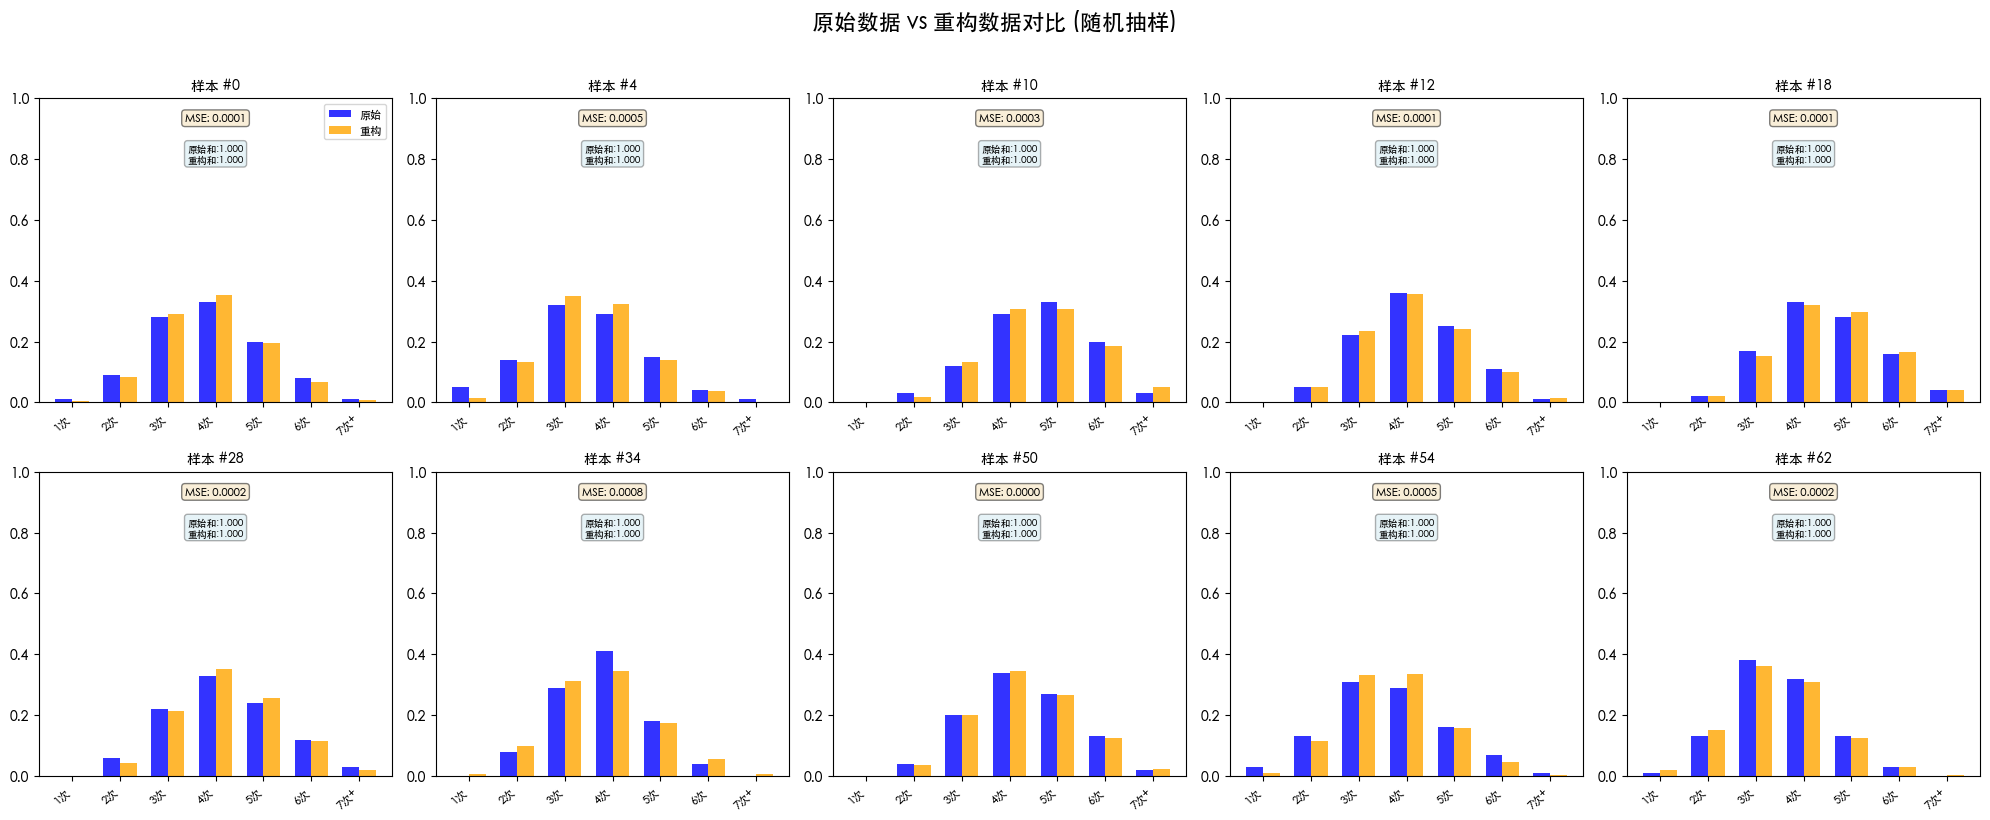


整体重构误差:
  MSE: 0.000551
  MAE: 0.015493

随机抽样的样本索引: [ 0  4 10 12 18 28 34 50 54 62]

数据和的一致性检查:
  原始数据平均和: 1.000000
  重构数据平均和: 1.000000
  和的标准差 - 原始: 0.000000
  和的标准差 - 重构: 0.000000


In [10]:
# 可视化对比：原始数据 vs 重构数据
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Heiti TC'  # 替换为你选择的字体

# 获取完整的重构数据（包含softmax归一化）
reconstructed_data = autoencoder(x_test).numpy()

# 随机抽样10个样本进行对比
n_samples = 10
np.random.seed(42)  # 设置随机种子确保可重复性
sample_indices = np.random.choice(len(x_test), n_samples, replace=False)
sample_indices = np.sort(sample_indices)  # 排序以便查看

feature_names = ['1次', '2次', '3次', '4次', '5次', '6次', '7次+']

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('原始数据 vs 重构数据对比 (随机抽样)', fontsize=16, y=1.02)

for plot_idx, sample_idx in enumerate(sample_indices):
    row = plot_idx // 5
    col = plot_idx % 5
    ax = axes[row, col]
    
    x_pos = np.arange(len(feature_names))
    width = 0.35
    
    # 绘制原始数据和重构数据的对比柱状图
    ax.bar(x_pos - width/2, x_test[sample_idx], width, label='原始', alpha=0.8, color='blue')
    ax.bar(x_pos + width/2, reconstructed_data[sample_idx], width, label='重构', alpha=0.8, color='orange')
    
    ax.set_title(f'样本 #{sample_idx}', fontsize=10)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(feature_names, rotation=45, ha='right', fontsize=8)
    ax.set_ylim([0, 1])
    
    if plot_idx == 0:
        ax.legend(fontsize=8)
    
    # 计算并显示重构误差
    mse = np.mean((x_test[sample_idx] - reconstructed_data[sample_idx])**2)
    ax.text(0.5, 0.95, f'MSE: {mse:.4f}', 
            transform=ax.transAxes, ha='center', va='top', 
            fontsize=8, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 显示数据和确保可比性
    ax.text(0.5, 0.85, f'原始和:{x_test[sample_idx].sum():.3f}\n重构和:{reconstructed_data[sample_idx].sum():.3f}', 
            transform=ax.transAxes, ha='center', va='top', 
            fontsize=7, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.tight_layout()
plt.show()

# 计算整体重构误差
overall_mse = np.mean((x_test - reconstructed_data)**2)
overall_mae = np.mean(np.abs(x_test - reconstructed_data))

print(f"\n整体重构误差:")
print(f"  MSE: {overall_mse:.6f}")
print(f"  MAE: {overall_mae:.6f}")

print(f"\n随机抽样的样本索引: {sample_indices}")

# 验证数据和的一致性
print(f"\n数据和的一致性检查:")
print(f"  原始数据平均和: {x_test.sum(axis=1).mean():.6f}")
print(f"  重构数据平均和: {reconstructed_data.sum(axis=1).mean():.6f}")
print(f"  和的标准差 - 原始: {x_test.sum(axis=1).std():.6f}")
print(f"  和的标准差 - 重构: {reconstructed_data.sum(axis=1).std():.6f}")

### 降维后的特征分布

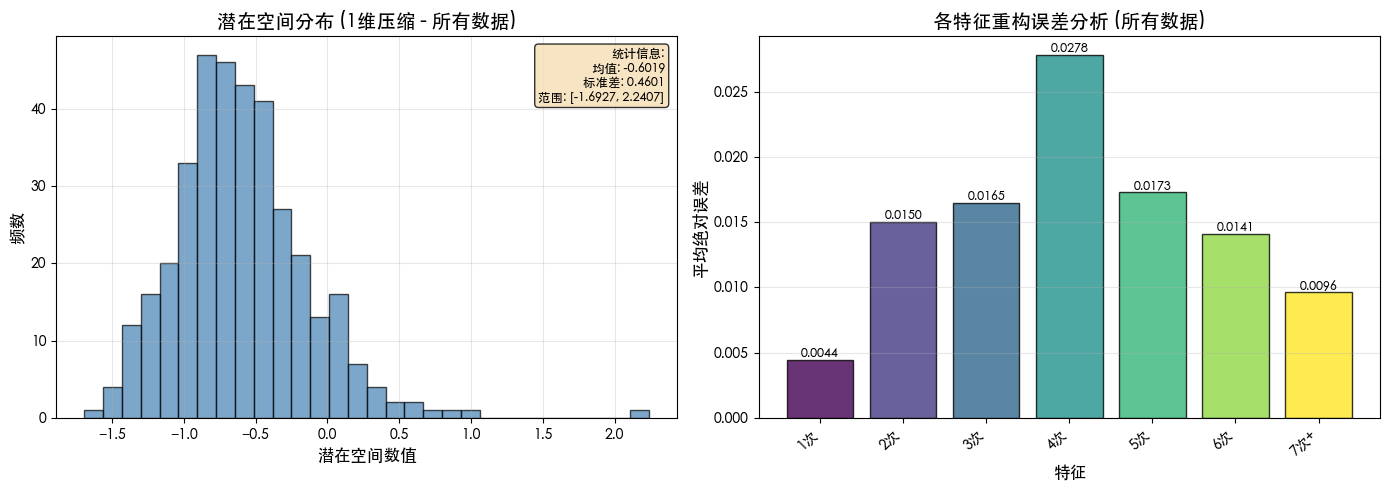


潜在空间编码统计 (基于 359 个样本):
  均值: -0.601918
  标准差: 0.460145
  中位数: -0.643557
  范围: [-1.692652, 2.240749]

各特征重构误差:
  1次      : 0.004411
  2次      : 0.014976
  3次      : 0.016488
  4次      : 0.027847
  5次      : 0.017324
  6次      : 0.014076
  7次+     : 0.009615
  总体平均: 0.014962


In [11]:
# 可视化潜在空间分布
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：潜在空间的分布
ax1 = axes[0]
ax1.hist(encoded_data.flatten(), bins=30, edgecolor='black', alpha=0.7, color='steelblue')
ax1.set_xlabel('潜在空间数值', fontsize=12)
ax1.set_ylabel('频数', fontsize=12)
ax1.set_title('潜在空间分布 (1维压缩 - 所有数据)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 添加统计信息文本框
stats_text = f'统计信息:\n均值: {encoded_data.mean():.4f}\n标准差: {encoded_data.std():.4f}\n范围: [{encoded_data.min():.4f}, {encoded_data.max():.4f}]'
ax1.text(0.98, 0.97, stats_text, transform=ax1.transAxes, 
         fontsize=9, verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# 右图：每个特征的重构误差
ax2 = axes[1]
# 使用完整的重构数据（包含softmax归一化）
reconstructed_all = autoencoder(x_all).numpy()
feature_errors = np.mean(np.abs(x_all - reconstructed_all), axis=0)
colors = plt.cm.viridis(np.linspace(0, 1, len(feature_names)))
bars = ax2.bar(feature_names, feature_errors, color=colors, edgecolor='black', alpha=0.8)
ax2.set_xlabel('特征', fontsize=12)
ax2.set_ylabel('平均绝对误差', fontsize=12)
ax2.set_title('各特征重构误差分析 (所有数据)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 在柱状图上显示数值
for bar, error in zip(bars, feature_errors):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{error:.4f}',
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# 打印详细统计
print(f"\n潜在空间编码统计 (基于 {len(x_all)} 个样本):")
print(f"  均值: {encoded_data.mean():.6f}")
print(f"  标准差: {encoded_data.std():.6f}")
print(f"  中位数: {np.median(encoded_data):.6f}")
print(f"  范围: [{encoded_data.min():.6f}, {encoded_data.max():.6f}]")

print(f"\n各特征重构误差:")
for name, error in zip(feature_names, feature_errors):
    print(f"  {name:8s}: {error:.6f}")
print(f"  总体平均: {feature_errors.mean():.6f}")

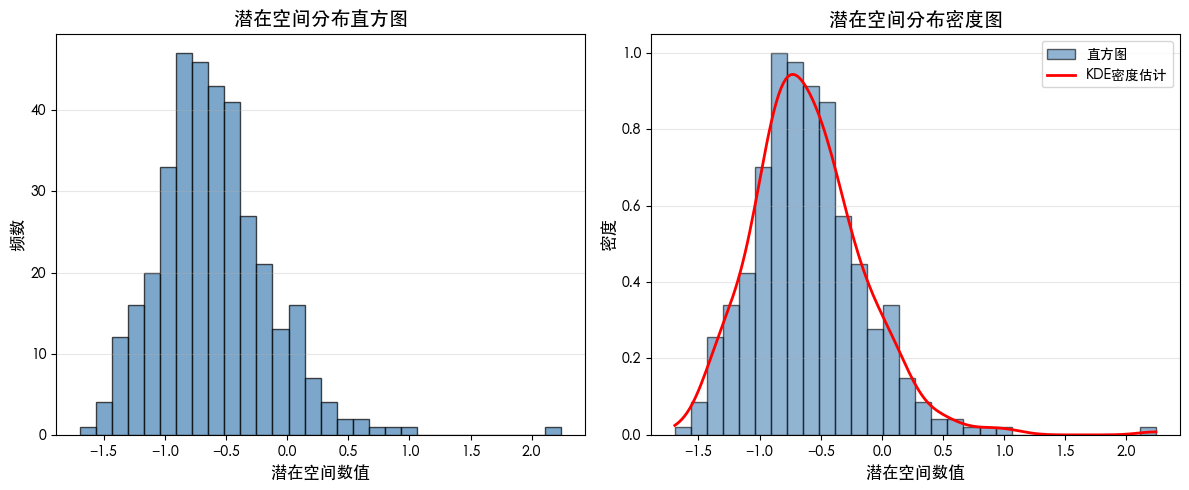

潜在空间分布统计信息:
  均值: -0.601918
  标准差: 0.460145
  最小值: -1.692652
  最大值: 2.240749
  中位数: -0.643557


In [12]:
from scipy import stats

# 绘制潜在空间分布的直方分布图
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 左图：直方图
plt.subplot(1, 2, 1)
plt.hist(encoded_data.flatten(), bins=30, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('潜在空间数值', fontsize=12)
plt.ylabel('频数', fontsize=12)
plt.title('潜在空间分布直方图', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# 右图：密度分布
plt.subplot(1, 2, 2)
plt.hist(encoded_data.flatten(), bins=30, density=True, alpha=0.6, 
         edgecolor='black', color='steelblue', label='直方图')
kde = stats.gaussian_kde(encoded_data.flatten())
x_range = np.linspace(encoded_data.min(), encoded_data.max(), 200)
plt.plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE密度估计')
plt.xlabel('潜在空间数值', fontsize=12)
plt.ylabel('密度', fontsize=12)
plt.title('潜在空间分布密度图', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 统计信息
print("潜在空间分布统计信息:")
print(f"  均值: {encoded_data.mean():.6f}")
print(f"  标准差: {encoded_data.std():.6f}")
print(f"  最小值: {encoded_data.min():.6f}")
print(f"  最大值: {encoded_data.max():.6f}")
print(f"  中位数: {np.median(encoded_data):.6f}")

### 模型解释

#### 降维后的值与各次尝试的相关性分析

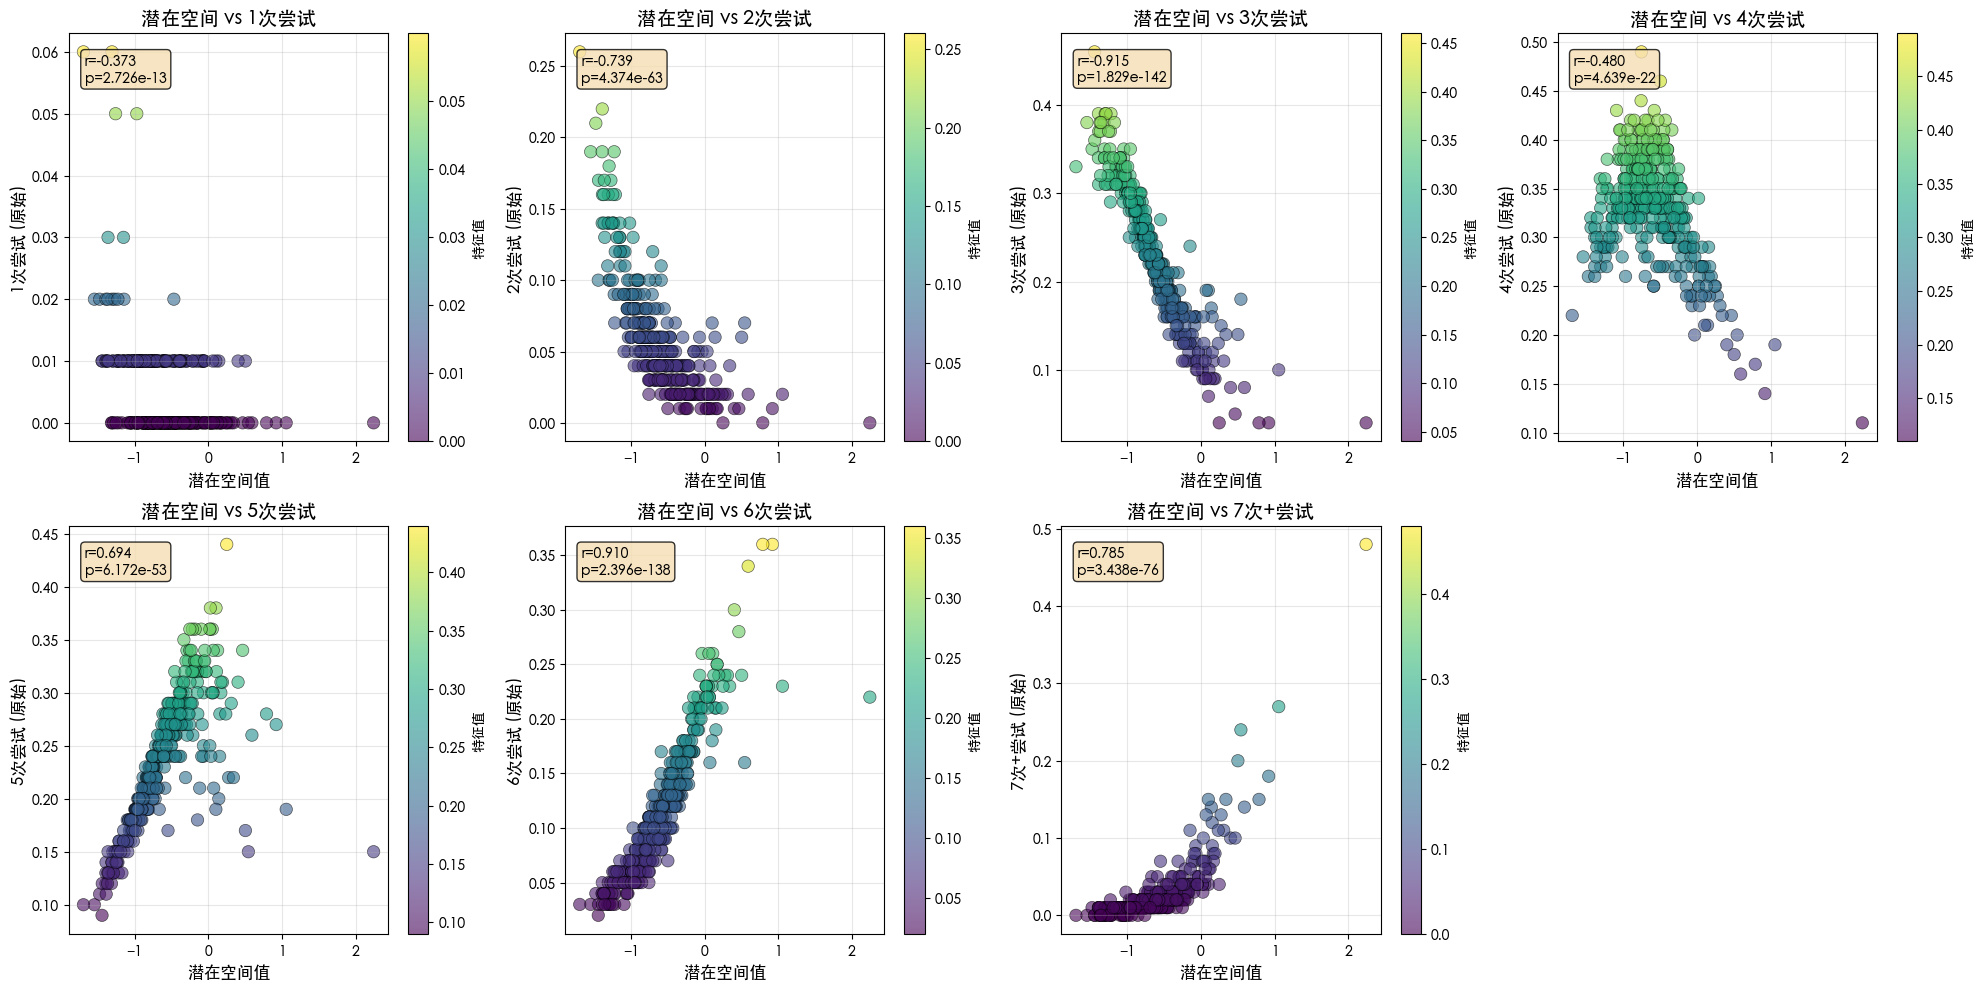


数据降维效果:
原始维度: 7 → 潜在维度: 1
压缩率: 85.7%
数据量: 359 个样本


In [13]:
from scipy.stats import pearsonr

# 散点图：潜在空间表示 vs 原始数据所有特征
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# 所有7个特征
selected_features = list(range(7))  # 0-6对应所有特征
selected_names = ['1次尝试', '2次尝试', '3次尝试', '4次尝试', '5次尝试', '6次尝试', '7次+尝试']

for idx, (feat_idx, feat_name) in enumerate(zip(selected_features, selected_names)):
    ax = axes[idx]
    scatter = ax.scatter(encoded_data.flatten(), x_all[:, feat_idx], 
                        c=x_all[:, feat_idx], cmap='viridis', 
                        s=80, alpha=0.6, edgecolors='black', linewidth=0.5)
    ax.set_xlabel('潜在空间值', fontsize=12)
    ax.set_ylabel(f'{feat_name} (原始)', fontsize=12)
    ax.set_title(f'潜在空间 vs {feat_name}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # 计算相关系数
    corr, pval = pearsonr(encoded_data.flatten(), x_all[:, feat_idx])
    
    # 添加相关系数文本
    ax.text(0.05, 0.95, f'r={corr:.3f}\np={pval:.3e}', 
            transform=ax.transAxes, fontsize=10,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.colorbar(scatter, ax=ax, label='特征值')

# 隐藏最后一个空白子图
axes[7].axis('off')

plt.tight_layout()
plt.show()

print("\n数据降维效果:")
print(f"原始维度: {x_all.shape[1]} → 潜在维度: {encoded_data.shape[1]}")
print(f"压缩率: {(1 - encoded_data.shape[1]/x_all.shape[1]) * 100:.1f}%")
print(f"数据量: {len(x_all)} 个样本")

In [14]:
# 计算编码值与原始特征的相关性分析（使用所有数据）
from scipy.stats import pearsonr, spearmanr

print("=" * 90)
print("编码值与原始特征的相关性分析 (基于所有数据)")
print("=" * 90)
print(f"数据量: {len(x_all)} 个样本")
print(f"潜在空间维度: {encoded_data.shape[1]}")

feature_names = ['1次尝试', '2次尝试', '3次尝试', '4次尝试', '5次尝试', '6次尝试', '7次+尝试']

correlation_results = []

for idx, feature_name in enumerate(feature_names):
    # 计算 Pearson 相关系数
    pearson_corr, pearson_pvalue = pearsonr(encoded_data.flatten(), x_all[:, idx])
    
    # 计算 Spearman 相关系数
    spearman_corr, spearman_pvalue = spearmanr(encoded_data.flatten(), x_all[:, idx])
    
    correlation_results.append({
        '特征': feature_name,
        'Pearson相关系数': pearson_corr,
        'Pearson p-value': pearson_pvalue,
        'Spearman相关系数': spearman_corr,
        'Spearman p-value': spearman_pvalue
    })
    
    print(f"\n{feature_name}:")
    print(f"  Pearson 相关系数:  {pearson_corr:>7.4f}  (p-value: {pearson_pvalue:.4e})")
    print(f"  Spearman 相关系数: {spearman_corr:>7.4f}  (p-value: {spearman_pvalue:.4e})")

# 转换为DataFrame以便更好地展示
correlation_df = pd.DataFrame(correlation_results)
print("\n" + "-" * 90)
print("相关性分析汇总表:")
print("-" * 90)
print(correlation_df.to_string(index=False))

# 显著性标注
print("\n" + "-" * 90)
print("相关性解读 (显著性水平 α=0.05):")
print("-" * 90)
for idx_row, row in correlation_df.iterrows():
    pearson_sig = "显著 ✓" if row['Pearson p-value'] < 0.05 else "不显著"
    spearman_sig = "显著 ✓" if row['Spearman p-value'] < 0.05 else "不显著"
    
    pearson_strength = "强" if abs(row['Pearson相关系数']) > 0.7 else "中等" if abs(row['Pearson相关系数']) > 0.4 else "弱"
    spearman_strength = "强" if abs(row['Spearman相关系数']) > 0.7 else "中等" if abs(row['Spearman相关系数']) > 0.4 else "弱"
    
    direction_p = "正相关" if row['Pearson相关系数'] > 0 else "负相关"
    direction_s = "正相关" if row['Spearman相关系数'] > 0 else "负相关"
    
    print(f"\n{row['特征']}:")
    print(f"  Pearson:  {pearson_strength}{direction_p} ({pearson_sig})")
    print(f"  Spearman: {spearman_strength}{direction_s} ({spearman_sig})")


编码值与原始特征的相关性分析 (基于所有数据)
数据量: 359 个样本
潜在空间维度: 1

1次尝试:
  Pearson 相关系数:  -0.3730  (p-value: 2.7261e-13)
  Spearman 相关系数: -0.3766  (p-value: 1.5433e-13)

2次尝试:
  Pearson 相关系数:  -0.7385  (p-value: 4.3738e-63)
  Spearman 相关系数: -0.8263  (p-value: 5.0021e-91)

3次尝试:
  Pearson 相关系数:  -0.9146  (p-value: 1.8288e-142)
  Spearman 相关系数: -0.9690  (p-value: 8.0141e-219)

4次尝试:
  Pearson 相关系数:  -0.4797  (p-value: 4.6392e-22)
  Spearman 相关系数: -0.3210  (p-value: 4.7944e-10)

5次尝试:
  Pearson 相关系数:   0.6943  (p-value: 6.1718e-53)
  Spearman 相关系数:  0.8388  (p-value: 2.8292e-96)

6次尝试:
  Pearson 相关系数:   0.9097  (p-value: 2.3957e-138)
  Spearman 相关系数:  0.9512  (p-value: 2.5844e-184)

7次+尝试:
  Pearson 相关系数:   0.7848  (p-value: 3.4378e-76)
  Spearman 相关系数:  0.8407  (p-value: 3.9374e-97)

------------------------------------------------------------------------------------------
相关性分析汇总表:
------------------------------------------------------------------------------------------
   特征  Pearson相关系数  Pearson p-valu

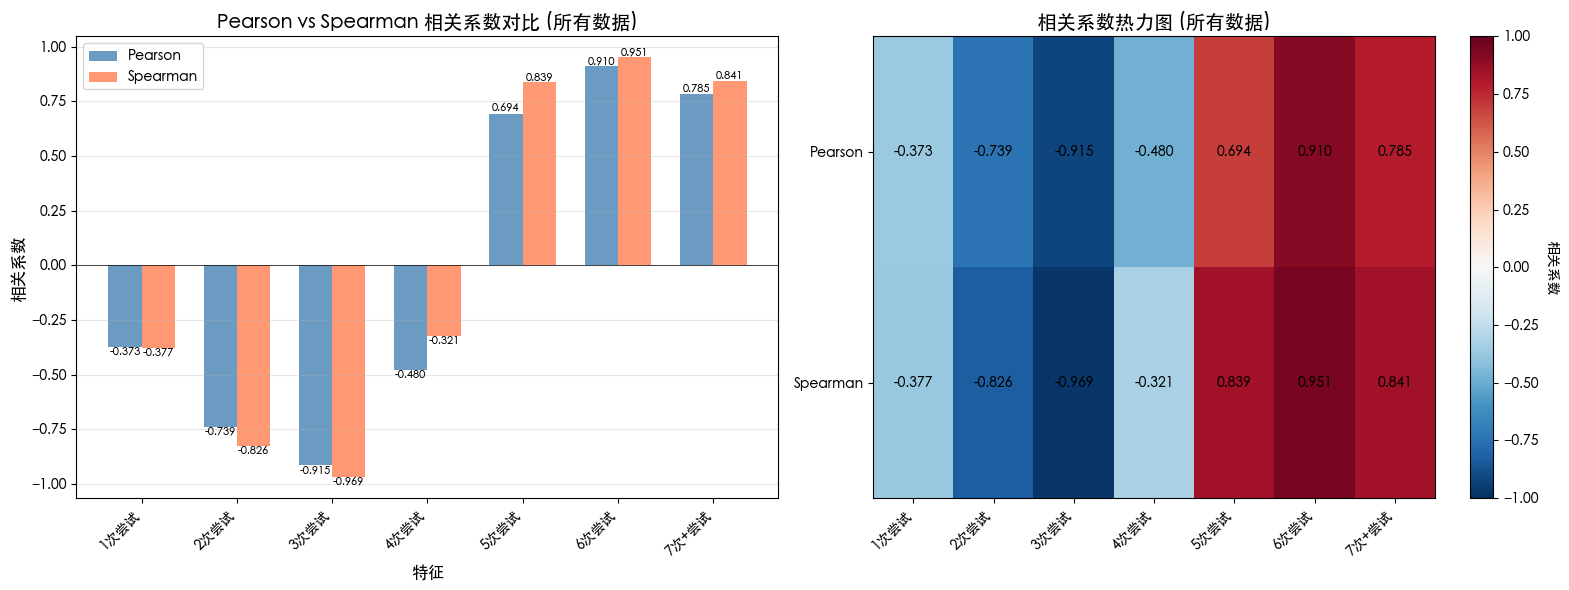


分析数据量: 359 个样本 (训练集: 287, 测试集: 72)


In [15]:
# 可视化相关性系数
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 提取相关系数
pearson_corrs = [r['Pearson相关系数'] for r in correlation_results]
spearman_corrs = [r['Spearman相关系数'] for r in correlation_results]

x = np.arange(len(feature_names))
width = 0.35

# 左图：Pearson vs Spearman 对比
bars1 = ax1.bar(x - width/2, pearson_corrs, width, label='Pearson', alpha=0.8, color='steelblue')
bars2 = ax1.bar(x + width/2, spearman_corrs, width, label='Spearman', alpha=0.8, color='coral')

ax1.set_xlabel('特征', fontsize=12)
ax1.set_ylabel('相关系数', fontsize=12)
ax1.set_title('Pearson vs Spearman 相关系数对比 (所有数据)', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(feature_names, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# 在柱状图上显示数值
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom' if height > 0 else 'top', 
                fontsize=8)

# 右图：相关性热力图
correlation_matrix = np.array([pearson_corrs, spearman_corrs])
im = ax2.imshow(correlation_matrix, cmap='RdBu_r', aspect='auto', vmin=-1, vmax=1)

ax2.set_xticks(x)
ax2.set_xticklabels(feature_names, rotation=45, ha='right')
ax2.set_yticks([0, 1])
ax2.set_yticklabels(['Pearson', 'Spearman'])
ax2.set_title('相关系数热力图 (所有数据)', fontsize=14, fontweight='bold')

# 添加数值标注
for i in range(2):
    for j in range(len(feature_names)):
        text = ax2.text(j, i, f'{correlation_matrix[i, j]:.3f}',
                       ha="center", va="center", color="black", fontsize=10,
                       fontweight='bold')

# 添加颜色条
cbar = plt.colorbar(im, ax=ax2)
cbar.set_label('相关系数', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()

# 添加数据量说明
print(f"\n分析数据量: {len(x_all)} 个样本 (训练集: {len(x_train)}, 测试集: {len(x_test)})")

#### 降维后的值与总期望分析

期望的计算公式为:

$E(难度) = 1 * X_{尝试1次} + 2 * X_{尝试2次} + 3 * X_{尝试3次} + 4 * X_{尝试4次} + 5 * X_{尝试5次} + 6 * X_{尝试6次} + 7 * X_{失败}$

期望尝试次数与潜在空间编码值的相关性分析
数据量: 359 个样本
潜在空间维度: 1

期望尝试次数统计:
  均值: 4.1933
  标准差: 0.3948
  范围: [3.1300, 5.9900]

相关性分析:
  Pearson 相关系数:   0.9909  (p-value: 1.3188e-312)
  Spearman 相关系数:  0.9987  (p-value: 0.0000e+00)

相关性解读 (显著性水平 α=0.05):
  Pearson:  强正相关 (显著 ✓)
  Spearman: 强正相关 (显著 ✓)


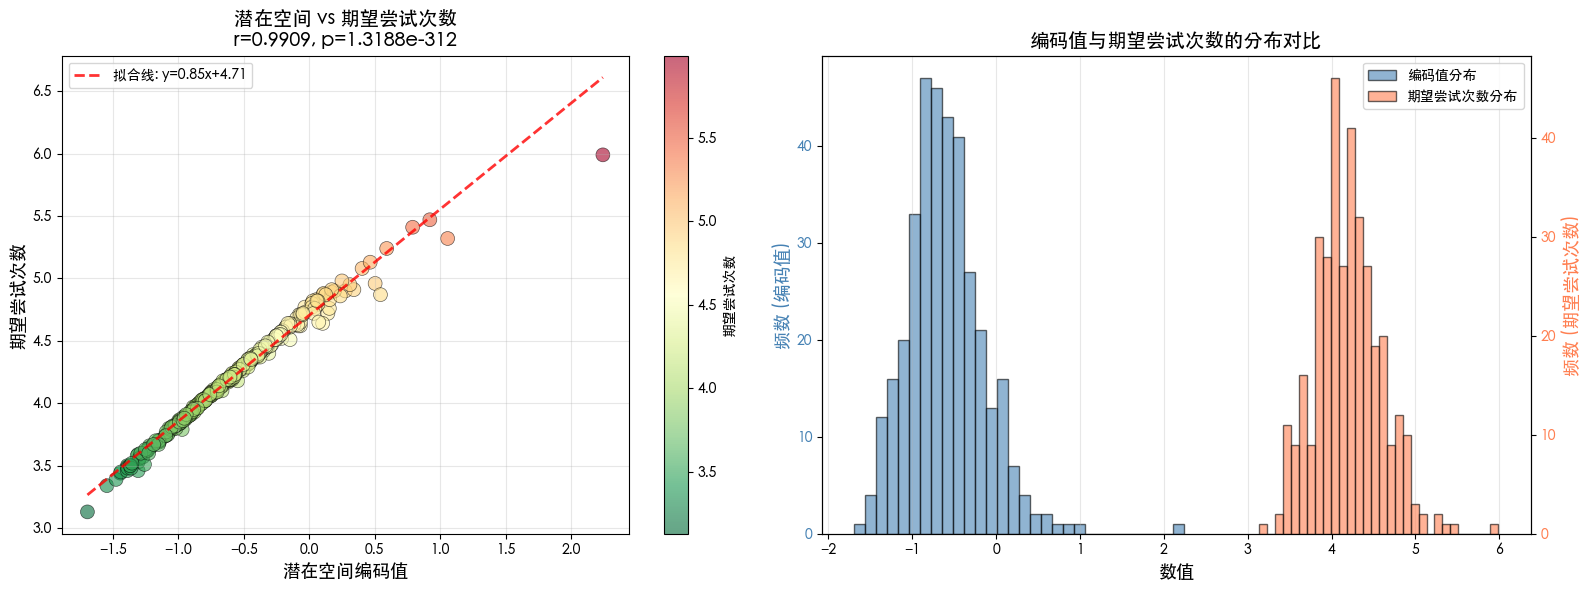


结论:
✓ 潜在空间编码值与期望尝试次数存在强相关性
  编码值能够有效表征游戏难度（尝试次数越多，难度越大）


In [16]:
from scipy.stats import pearsonr, spearmanr

# 计算多次尝试的期望值与编码后的值的相关性

# 计算每个样本的期望尝试次数
# 每个特征代表 1-7 次尝试的百分比
attempt_numbers = np.array([1, 2, 3, 4, 5, 6, 7])
expected_attempts = np.sum(x_all * attempt_numbers, axis=1)

print("=" * 90)
print("期望尝试次数与潜在空间编码值的相关性分析")
print("=" * 90)
print(f"数据量: {len(x_all)} 个样本")
print(f"潜在空间维度: {encoded_data.shape[1]}")

# 计算相关性
pearson_corr, pearson_pval = pearsonr(encoded_data.flatten(), expected_attempts)
spearman_corr, spearman_pval = spearmanr(encoded_data.flatten(), expected_attempts)

print(f"\n期望尝试次数统计:")
print(f"  均值: {expected_attempts.mean():.4f}")
print(f"  标准差: {expected_attempts.std():.4f}")
print(f"  范围: [{expected_attempts.min():.4f}, {expected_attempts.max():.4f}]")

print(f"\n相关性分析:")
print(f"  Pearson 相关系数:  {pearson_corr:>7.4f}  (p-value: {pearson_pval:.4e})")
print(f"  Spearman 相关系数: {spearman_corr:>7.4f}  (p-value: {spearman_pval:.4e})")

# 显著性判断
pearson_sig = "显著 ✓" if pearson_pval < 0.05 else "不显著"
spearman_sig = "显著 ✓" if spearman_pval < 0.05 else "不显著"

pearson_strength = "强" if abs(pearson_corr) > 0.7 else "中等" if abs(pearson_corr) > 0.4 else "弱"
spearman_strength = "强" if abs(spearman_corr) > 0.7 else "中等" if abs(spearman_corr) > 0.4 else "弱"

direction = "正相关" if pearson_corr > 0 else "负相关"

print(f"\n相关性解读 (显著性水平 α=0.05):")
print(f"  Pearson:  {pearson_strength}{direction} ({pearson_sig})")
print(f"  Spearman: {spearman_strength}{direction} ({spearman_sig})")

# 可视化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 左图：散点图
scatter = ax1.scatter(encoded_data.flatten(), expected_attempts, 
                     c=expected_attempts, cmap='RdYlGn_r', 
                     s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
ax1.set_xlabel('潜在空间编码值', fontsize=13)
ax1.set_ylabel('期望尝试次数', fontsize=13)
ax1.set_title(f'潜在空间 vs 期望尝试次数\nr={pearson_corr:.4f}, p={pearson_pval:.4e}', 
             fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 添加趋势线
z = np.polyfit(encoded_data.flatten(), expected_attempts, 1)
p = np.poly1d(z)
x_trend = np.linspace(encoded_data.min(), encoded_data.max(), 100)
ax1.plot(x_trend, p(x_trend), "r--", linewidth=2, alpha=0.8, label=f'拟合线: y={z[0]:.2f}x+{z[1]:.2f}')
ax1.legend(fontsize=10)

plt.colorbar(scatter, ax=ax1, label='期望尝试次数')

# 右图：分布对比
ax2_1 = ax2
ax2_2 = ax2.twinx()

# 编码值分布
ax2_1.hist(encoded_data.flatten(), bins=30, alpha=0.6, color='steelblue', 
          edgecolor='black', label='编码值分布')
ax2_1.set_xlabel('数值', fontsize=13)
ax2_1.set_ylabel('频数 (编码值)', fontsize=13, color='steelblue')
ax2_1.tick_params(axis='y', labelcolor='steelblue')

# 期望尝试次数分布
ax2_2.hist(expected_attempts, bins=30, alpha=0.6, color='coral', 
          edgecolor='black', label='期望尝试次数分布')
ax2_2.set_ylabel('频数 (期望尝试次数)', fontsize=13, color='coral')
ax2_2.tick_params(axis='y', labelcolor='coral')

ax2.set_title('编码值与期望尝试次数的分布对比', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# 合并图例
lines1, labels1 = ax2_1.get_legend_handles_labels()
lines2, labels2 = ax2_2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "=" * 90)
print("结论:")
print("=" * 90)
if abs(pearson_corr) > 0.7 and pearson_pval < 0.05:
    print("✓ 潜在空间编码值与期望尝试次数存在强相关性")
    print(f"  编码值能够有效表征游戏难度（尝试次数越多，难度越大）")
elif abs(pearson_corr) > 0.4 and pearson_pval < 0.05:
    print("✓ 潜在空间编码值与期望尝试次数存在中等相关性")
    print(f"  编码值在一定程度上反映了游戏难度")
else:
    print("⚠ 潜在空间编码值与期望尝试次数相关性较弱")
    print(f"  编码值可能捕获了其他潜在模式，而非单纯的难度指标")

这里将期望的计算公式改为:

$E(难度) = 1 * X_{尝试1次} + 2 * X_{尝试2次} + 3 * X_{尝试3次} + 4 * X_{尝试4次} + 5 * X_{尝试5次} + 6 * X_{尝试6次} + 9 * X_{失败}$

会发现最后的拟合值会好很多，期望更符合正态分布

说明失败不能用“尝试7次”来解释，把“尝试9次“作为失败解释更符合实际情况 

（有趣的发现？那些失败的人更可能要尝试9次才能成功？）

期望尝试次数与潜在空间编码值的相关性分析
数据量: 359 个样本
潜在空间维度: 1

期望尝试次数统计:
  均值: 4.2494
  标准差: 0.4567
  范围: [3.1300, 6.9500]

相关性分析:
  Pearson 相关系数:   0.9989  (p-value: 0.0000e+00)
  Spearman 相关系数:  0.9991  (p-value: 0.0000e+00)

相关性解读 (显著性水平 α=0.05):
  Pearson:  强正相关 (显著 ✓)
  Spearman: 强正相关 (显著 ✓)


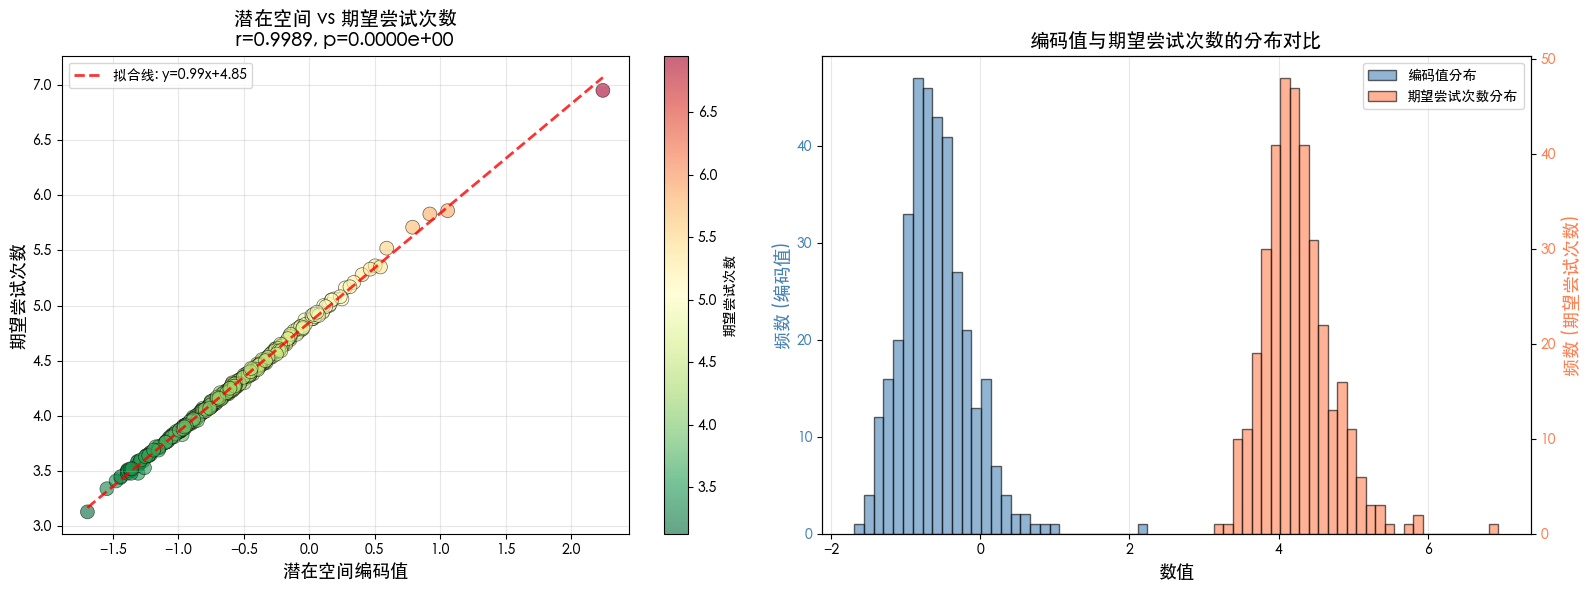


结论:
✓ 潜在空间编码值与期望尝试次数存在强相关性
  编码值能够有效表征游戏难度（尝试次数越多，难度越大）


In [21]:
from scipy.stats import pearsonr, spearmanr

# 计算多次尝试的期望值与编码后的值的相关性

# 计算每个样本的期望尝试次数
# 每个特征代表 1-7 次尝试的百分比
attempt_numbers = np.array([1, 2, 3, 4, 5, 6, 9])
expected_attempts = np.sum(x_all * attempt_numbers, axis=1)

print("=" * 90)
print("期望尝试次数与潜在空间编码值的相关性分析")
print("=" * 90)
print(f"数据量: {len(x_all)} 个样本")
print(f"潜在空间维度: {encoded_data.shape[1]}")

# 计算相关性
pearson_corr, pearson_pval = pearsonr(encoded_data.flatten(), expected_attempts)
spearman_corr, spearman_pval = spearmanr(encoded_data.flatten(), expected_attempts)

print(f"\n期望尝试次数统计:")
print(f"  均值: {expected_attempts.mean():.4f}")
print(f"  标准差: {expected_attempts.std():.4f}")
print(f"  范围: [{expected_attempts.min():.4f}, {expected_attempts.max():.4f}]")

print(f"\n相关性分析:")
print(f"  Pearson 相关系数:  {pearson_corr:>7.4f}  (p-value: {pearson_pval:.4e})")
print(f"  Spearman 相关系数: {spearman_corr:>7.4f}  (p-value: {spearman_pval:.4e})")

# 显著性判断
pearson_sig = "显著 ✓" if pearson_pval < 0.05 else "不显著"
spearman_sig = "显著 ✓" if spearman_pval < 0.05 else "不显著"

pearson_strength = "强" if abs(pearson_corr) > 0.7 else "中等" if abs(pearson_corr) > 0.4 else "弱"
spearman_strength = "强" if abs(spearman_corr) > 0.7 else "中等" if abs(spearman_corr) > 0.4 else "弱"

direction = "正相关" if pearson_corr > 0 else "负相关"

print(f"\n相关性解读 (显著性水平 α=0.05):")
print(f"  Pearson:  {pearson_strength}{direction} ({pearson_sig})")
print(f"  Spearman: {spearman_strength}{direction} ({spearman_sig})")

# 可视化
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 左图：散点图
scatter = ax1.scatter(encoded_data.flatten(), expected_attempts, 
                     c=expected_attempts, cmap='RdYlGn_r', 
                     s=100, alpha=0.6, edgecolors='black', linewidth=0.5)
ax1.set_xlabel('潜在空间编码值', fontsize=13)
ax1.set_ylabel('期望尝试次数', fontsize=13)
ax1.set_title(f'潜在空间 vs 期望尝试次数\nr={pearson_corr:.4f}, p={pearson_pval:.4e}', 
             fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# 添加趋势线
z = np.polyfit(encoded_data.flatten(), expected_attempts, 1)
p = np.poly1d(z)
x_trend = np.linspace(encoded_data.min(), encoded_data.max(), 100)
ax1.plot(x_trend, p(x_trend), "r--", linewidth=2, alpha=0.8, label=f'拟合线: y={z[0]:.2f}x+{z[1]:.2f}')
ax1.legend(fontsize=10)

plt.colorbar(scatter, ax=ax1, label='期望尝试次数')

# 右图：分布对比
ax2_1 = ax2
ax2_2 = ax2.twinx()

# 编码值分布
ax2_1.hist(encoded_data.flatten(), bins=30, alpha=0.6, color='steelblue', 
          edgecolor='black', label='编码值分布')
ax2_1.set_xlabel('数值', fontsize=13)
ax2_1.set_ylabel('频数 (编码值)', fontsize=13, color='steelblue')
ax2_1.tick_params(axis='y', labelcolor='steelblue')

# 期望尝试次数分布
ax2_2.hist(expected_attempts, bins=30, alpha=0.6, color='coral', 
          edgecolor='black', label='期望尝试次数分布')
ax2_2.set_ylabel('频数 (期望尝试次数)', fontsize=13, color='coral')
ax2_2.tick_params(axis='y', labelcolor='coral')

ax2.set_title('编码值与期望尝试次数的分布对比', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

# 合并图例
lines1, labels1 = ax2_1.get_legend_handles_labels()
lines2, labels2 = ax2_2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "=" * 90)
print("结论:")
print("=" * 90)
if abs(pearson_corr) > 0.7 and pearson_pval < 0.05:
    print("✓ 潜在空间编码值与期望尝试次数存在强相关性")
    print(f"  编码值能够有效表征游戏难度（尝试次数越多，难度越大）")
elif abs(pearson_corr) > 0.4 and pearson_pval < 0.05:
    print("✓ 潜在空间编码值与期望尝试次数存在中等相关性")
    print(f"  编码值在一定程度上反映了游戏难度")
else:
    print("⚠ 潜在空间编码值与期望尝试次数相关性较弱")
    print(f"  编码值可能捕获了其他潜在模式，而非单纯的难度指标")